# Chapter 2: Multi-arm bandits

This chapter introduces the *k*-armed bandit problem, the conflict between exploration and exploitation, and several ways how to balance this conflict.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

## 2.1 *k*-Armed Bandit Problem

In [2]:
class Bandit:
    def __init__(self, k):
        # k: number of bandit arms
        self.k = k
        
        # qstar: action values
        self.qstar = np.random.normal(size=k)
    
    def action(self, a):
        return np.random.normal(loc=self.qstar[a])

## 2.2 Greedy action selection

In [3]:
def greedy_action_selection(k, numsteps):
    # k: number of bandit arms
    # numsteps: number of steps (repeated action selections)
    
    # Apossible[t]: list of possible actions at step t
    Apossible = {}
    
    # A[t]: action selected at step t
    A = np.zeros((numsteps,))
    
    # N[a,t]: the number of times action a was selected 
    #         in steps 0 through t-1
    N = np.zeros((k,numsteps+1))
    
    # R[t]: reward at step t
    R = np.zeros((numsteps,))
    
    # Q[a,t]: estimated value of action a at step t
    Q = np.zeros((k,(numsteps+1)))

    # Initialize bandit
    bandit = Bandit(k)

    for t in range(numsteps):

        # Select greedy actions as possible actions
        Apossible[t] = np.argwhere(Q[:,t] == np.amax(Q[:,t])).flatten()

        # Select action randomly from possible actions
        a = Apossible[t][np.random.randint(len(Apossible[t]))]

        # Record action taken
        A[t] = a

        # Perform action (= sample reward)
        R[t] = bandit.action(a)

        # Update action counts
        N[:,t+1] = N[:,t]
        N[a,t+1] += 1

        # Update action value estimates, incrementally
        if N[a,t] > 0:
            Q[:,t+1] = Q[:,t]
            Q[a,t+1] = Q[a,t] + (R[t] - Q[a,t]) / N[a,t]
        else:
            Q[:,t+1] = Q[:,t]
            Q[a,t+1] = R[t]

    return {'bandit': bandit, 
            'Apossible': Apossible, 
            'A': A, 'N' : N, 'R' : R, 'Q' : Q}

### 2.2.1 Single run of a greedy action selection bandit

In [4]:
k = 10
numsteps = 1000
bandit_task = greedy_action_selection(k, numsteps)

print(bandit_task['bandit'].qstar)

[-0.40734403  0.69564736 -0.22631037  0.15601736  1.51400309 -0.66978217
  1.72522727  0.39519034 -0.25063334 -0.57299005]


### 2.2.2 Test bed, greedy action

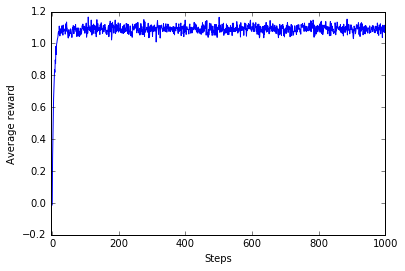

In [5]:
k = 10
numsteps = 1000
numtasks = 2000

avgR = np.zeros((numsteps, ))
for task in range(2000):
    bandit_task = greedy_action_selection(k,numsteps)
    avgR += bandit_task['R']
avgR /= numtasks

plt.plot(avgR) ;
plt.ylabel('Average reward') ;
plt.xlabel('Steps') ;
plt.xlim(-5) ;

## 2.3 $\varepsilon$-greedy action selection

In [6]:
def epsilon_greedy_action_selection(k, numsteps, epsilon):
    # k: number of bandit arms
    # numsteps: number of steps (repeated action selections)
    # epsilon: probability with which a random action is selected,
    #          as opposed to a greedy action

    # Apossible[t]: list of possible actions at step t
    Apossible = {}
    
    # A[t]: action selected at step t
    A = np.zeros((numsteps,))
    
    # N[a,t]: the number of times action a was selected 
    #         in steps 0 through t-1
    N = np.zeros((k,numsteps+1))
    
    # R[t]: reward at step t
    R = np.zeros((numsteps,))
    
    # Q[a,t]: estimated value of action a at step t
    Q = np.zeros((k,(numsteps+1)))

    # Initialize bandit
    bandit = Bandit(k)

    for t in range(numsteps):
        if np.random.rand() < epsilon:
            # All actions are equally possible
            Apossible[t] = np.arange(k)
        else:
            # Select greedy actions as possible actions
            Apossible[t] = np.argwhere(Q[:,t] == np.amax(Q[:,t])).flatten()

        # Select action randomly from possible actions
        a = Apossible[t][np.random.randint(len(Apossible[t]))]

        # Record action taken
        A[t] = a

        # Perform action (= sample reward)
        R[t] = bandit.action(a)

        # Update action counts
        N[:,t+1] = N[:,t]
        N[a,t+1] += 1

        # Update action value estimates, incrementally
        if N[a,t] > 0:
            Q[:,t+1] = Q[:,t]
            Q[a,t+1] = Q[a,t] + (R[t] - Q[a,t]) / N[a,t]
        else:
            Q[:,t+1] = Q[:,t]
            Q[a,t+1] = R[t]

    return {'bandit' : bandit,
            'numsteps' : numsteps,
            'epsilon' : epsilon,
            'Apossible': Apossible, 
            'A': A, 'N' : N, 'R' : R, 'Q' : Q}

### 2.3.1 Single $\varepsilon$-greedy run

In [15]:
k = 10
numsteps = 1000
epsilon = 0.1
bandit_task = epsilon_greedy_action_selection(k, numsteps, epsilon)
print('qstar:', bandit_task['bandit'].qstar)
print('Q:',bandit_task['Q'][:,numsteps])

qstar: [-0.17143012  1.5879512   0.09051276  0.69108154  0.00277714  0.25694229
  0.05702524 -0.16382875 -0.50687675 -0.73807627]
Q: [ 0.79458228  1.5940917  -0.36361199  0.50607431 -0.06502963 -0.10132587
 -0.16085761 -0.00187244 -0.76150491 -0.90644979]


### 2.3.2 Detailed look at a single run of $\varepsilon$-greedy action selection

In [31]:
def plot_bandit_task(bandit_task):
    numsteps = bandit_task['numsteps']
    qdist = np.zeros((numsteps,))
    for t in range(numsteps):
        qdist[t] = np.mean(np.square(bandit_task['bandit'].qstar - bandit_task['Q'][:,t]))

    # Plot
    f, axarr = plt.subplots(4, figsize=(12,18))
    axarr[0].scatter(range(bandit_task['bandit'].k),bandit_task['bandit'].qstar)
    axarr[0].set_title('q*')
    for i,val in enumerate(bandit_task['bandit'].qstar):
        axarr[0].annotate("{0:.2f}".format(val), (i-0.25,val+0.15))

    axarr[1].set_title('Reward')
    axarr[1].plot(bandit_task['R'])
    axarr[1].set_xlim(xmin=-50,xmax=numsteps)

    axarr[2].set_title('Distance Q - q*')
    axarr[2].plot(qdist)
    axarr[2].set_xlim(xmin=-50,xmax=numsteps)

    axarr[3].set_title('N')
    axarr[3].scatter(range(bandit_task['bandit'].k), bandit_task['N'][:,numsteps])
    for i,val in enumerate(bandit_task['N'][:,numsteps]):
        axarr[3].annotate("{0:.0f}".format(val), (i-0.1,val+50))

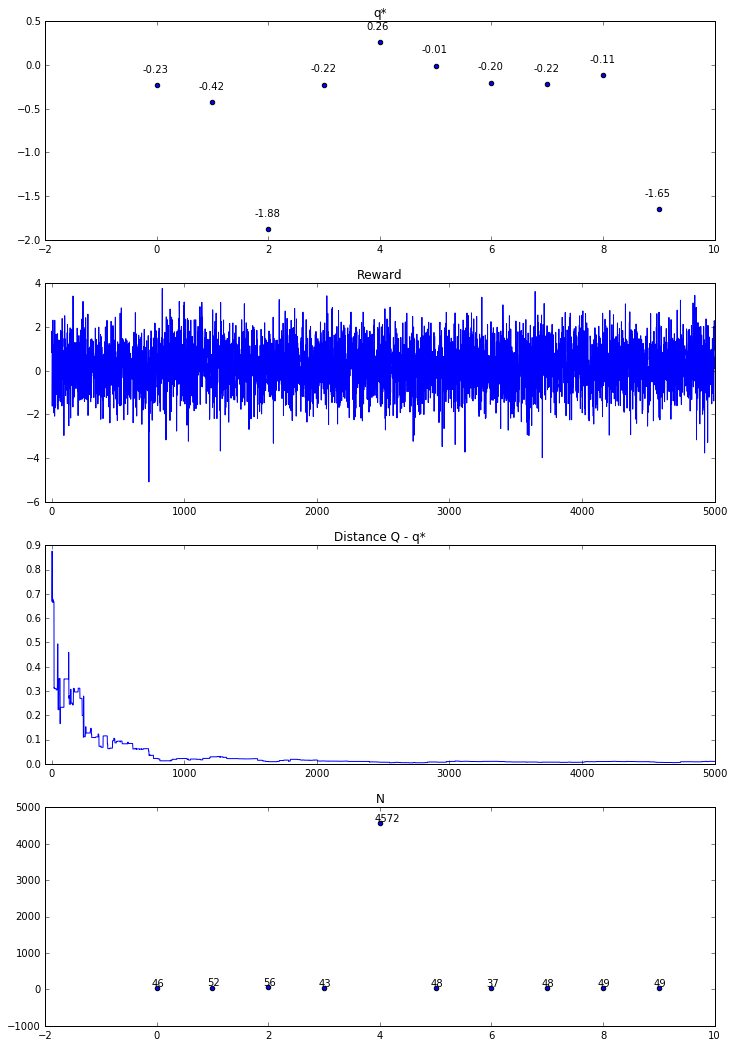

In [17]:
k = 10
numsteps = 5000
epsilon = 0.1
bandit_task = epsilon_greedy_action_selection(k, numsteps, epsilon)
plot_bandit_task(bandit_task)

### 2.3.3 Multiple $\varepsilon$-greedy runs

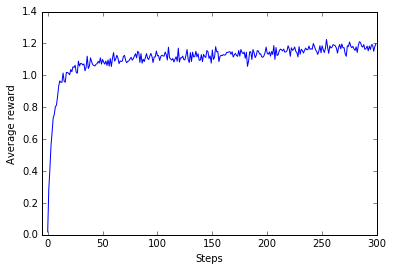

In [18]:
k = 10
numsteps = 300
numtasks = 2000
epsilon = 0.01

avgR = np.zeros((numsteps, ))
for task in range(2000):
    bandit_task = epsilon_greedy_action_selection(k,numsteps, epsilon)
    avgR += bandit_task['R']
avgR /= numtasks

plt.plot(avgR) ;
plt.ylabel('Average reward') ;
plt.xlabel('Steps') ;
plt.xlim(-5) ;

### 2.3.4 Comparisons of average reward with different $\varepsilon$ values

In [19]:
k = 10
numsteps = 500
numtasks = 2000
epsilon_a = 0.01
epsilon_b = 0.1

avgR_a = np.zeros((numsteps, ))
for task in range(2000):
    bandit_task = epsilon_greedy_action_selection(k,numsteps, epsilon_a)
    avgR_a += bandit_task['R']
avgR_a /= numtasks

avgR_b = np.zeros((numsteps, ))
for task in range(2000):
    bandit_task = epsilon_greedy_action_selection(k,numsteps, epsilon_b)
    avgR_b += bandit_task['R']
avgR_b /= numtasks

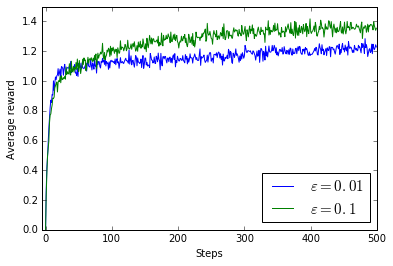

In [20]:
plt.plot(avgR_a, label=r'$\varepsilon = '+ str(epsilon_a) + '$') ;
plt.plot(avgR_b, label=r'$\varepsilon = '+ str(epsilon_b) + '$') ;
plt.ylabel('Average reward') ;
plt.xlabel('Steps') ;
plt.xlim(-5) ;
plt.ylim([0,1.5])
plt.legend(loc='lower right', fontsize=15) ;

## 2.4 Optimistic initial values

### 2.4.1 Definition

In [21]:
def greedy_action_selection_optimistic_initial_values(k, numsteps, Q0):
    # k: number of bandit arms
    # numsteps: number of steps (repeated action selections)
    # Q0: optimistic initial values
    
    # Apossible[t]: list of possible actions at step t
    Apossible = {}
    
    # A[t]: action selected at step t
    A = np.zeros((numsteps,))
    
    # N[a,t]: the number of times action a was selected 
    #         in steps 0 through t-1
    N = np.zeros((k,numsteps+1))
    
    # R[t]: reward at step t
    R = np.zeros((numsteps,))
    
    # Q[a,t]: estimated value of action a at step t
    Q = np.zeros((k,(numsteps+1)))
    
    Q[:,0] = Q0

    # Initialize bandit
    bandit = Bandit(k)

    for t in range(numsteps):

        # Select greedy actions as possible actions
        Apossible[t] = np.argwhere(Q[:,t] == np.amax(Q[:,t])).flatten()

        # Select action randomly from possible actions
        a = Apossible[t][np.random.randint(len(Apossible[t]))]

        # Record action taken
        A[t] = a

        # Perform action (= sample reward)
        R[t] = bandit.action(a)

        # Update action counts
        N[:,t+1] = N[:,t]
        N[a,t+1] += 1

        # Update action value estimates, incrementally
        if N[a,t] > 0:
            Q[:,t+1] = Q[:,t]
            Q[a,t+1] = Q[a,t] + (R[t] - Q[a,t]) / N[a,t]
        else:
            Q[:,t+1] = Q[:,t]
            Q[a,t+1] = R[t]

    return {'bandit': bandit, 
            'Apossible': Apossible, 
            'A': A, 'N' : N, 'R' : R, 'Q' : Q}

### 2.4.2 Comparison between optimistic intial value estimates and $\varepsilon$-greedy

In [22]:
k = 10
numsteps = 500
numtasks = 2000

Q0 = np.ones((k,)) * 5
avgR_a = np.zeros((numsteps, ))
for task in range(2000):
    bandit_task = greedy_action_selection_optimistic_initial_values(k,numsteps, Q0)
    avgR_a += bandit_task['R']
avgR_a /= numtasks

epsilon = 0.1
avgR_b = np.zeros((numsteps, ))
for task in range(2000):
    bandit_task = epsilon_greedy_action_selection(k,numsteps, epsilon)
    avgR_b += bandit_task['R']
avgR_b /= numtasks

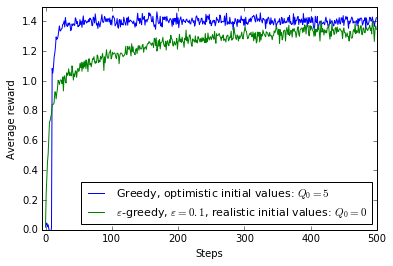

In [23]:
plt.plot(avgR_a, label=r'Greedy, optimistic initial values: $Q_0 = 5$') ;
plt.plot(avgR_b, label=(r'$\varepsilon$-greedy, $\varepsilon = ' 
                        + str(epsilon) + '$, realistic initial values: $Q_0 = 0$')) ;
plt.ylabel('Average reward') ;
plt.xlabel('Steps') ;
plt.xlim(-5) ;
plt.ylim([0,1.5])
plt.legend(loc='lower right', fontsize=11) ;

## 2.5 Upper-Confidence-Bound (UCB) Action Selection

### 2.5.1 Definition

In [24]:
def ucb_action_selection(k, numsteps, c):
    # k: number of bandit arms
    # numsteps: number of steps (repeated action selections)
    # c: parameter controlling the degree of exploration

    # Apossible[t]: list of possible actions at step t
    Apossible = {}
    
    # A[t]: action selected at step t
    A = np.zeros((numsteps,))
    
    # N[a,t]: the number of times action a was selected 
    #         in steps 0 through t-1
    N = np.zeros((k,numsteps+1))
    
    # R[t]: reward at step t
    R = np.zeros((numsteps,))
    
    # Q[a,t]: estimated value of action a at step t
    Q = np.zeros((k,(numsteps+1)))
    
    ucb = np.zeros((k, numsteps))

    # Initialize bandit
    bandit = Bandit(k)

    for t in range(numsteps):
        untaken_actions = np.where(N[:,t] == 0)[0]
    
        if len(untaken_actions) > 0:
            # If there are untaken actions, add them to possible actions
            Apossible[t] = untaken_actions
        else:
            # Otherwise, calculate UCB score for each action and select maximum
            ucb[:,t] = Q[:,t] + c*np.sqrt(np.log(t)/N[:,t])
            Apossible[t] = np.argwhere(ucb[:,t] == np.amax(ucb[:,t])).flatten()

        # Select action randomly from possible actions
        a = Apossible[t][np.random.randint(len(Apossible[t]))]

        # Record action taken
        A[t] = a

        # Perform action (= sample reward)
        R[t] = bandit.action(a)

        # Update action counts
        N[:,t+1] = N[:,t]
        N[a,t+1] += 1

        # Update action value estimates, incrementally
        if N[a,t] > 0:
            Q[:,t+1] = Q[:,t]
            Q[a,t+1] = Q[a,t] + (R[t] - Q[a,t]) / N[a,t]
        else:
            Q[:,t+1] = Q[:,t]
            Q[a,t+1] = R[t]

    return {'bandit' : bandit,
            'numsteps' : numsteps,
            'epsilon' : epsilon,
            'Apossible': Apossible,
            'ucb' : ucb,
            'A': A, 'N' : N, 'R' : R, 'Q' : Q}

### 2.5.2 Comparison between UCB and $\varepsilon$-greedy

In [25]:
k = 10
numsteps = 500
numtasks = 2000

epsilon = 0.1
avgR_a = np.zeros((numsteps, ))
for task in range(2000):
    bandit_task = epsilon_greedy_action_selection(k,numsteps, epsilon)
    avgR_a += bandit_task['R']
avgR_a /= numtasks

c = 2
avgR_b = np.zeros((numsteps, ))
for task in range(2000):
    bandit_task = ucb_action_selection(k,numsteps, c)
    avgR_b += bandit_task['R']
avgR_b /= numtasks

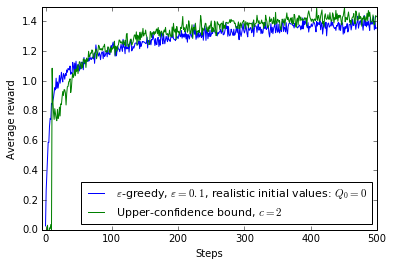

In [26]:
plt.plot(avgR_a, label=(r'$\varepsilon$-greedy, $\varepsilon = ' 
                        + str(epsilon) + '$, realistic initial values: $Q_0 = 0$')) ;
plt.plot(avgR_b, label=('Upper-confidence bound, $c=2$')) ;
plt.ylabel('Average reward') ;
plt.xlabel('Steps') ;
plt.xlim(-5) ;
plt.ylim([0,1.5])
plt.legend(loc='lower right', fontsize=11) ;

## 2.6 Gradient bandits

### 2.6.1 Definition

In [27]:
def gradient_bandit(k, numstep, alpha):
    # k: number of bandit arms
    # numsteps: number of steps (repeated action selections)
    # alpha: 
    
    # A[t]: action selected at step t
    A = np.zeros((numsteps,))
    
    # N[a,t]: the number of times action a was selected 
    #         in steps 0 through t-1
    N = np.zeros((k,numsteps+1))
    
    # R[t]: reward at step t
    R = np.zeros((numsteps,))
    
    # H[a,t]: preference for action a at step t
    H = np.zeros((k,(numsteps+1)))

    # Initialize bandit
    bandit = Bandit(k)

    for t in range(numsteps):
        # pi_t[a]: probability of selecting action a given preferences H
        pi_t = np.exp(H[:,t]) / np.sum(np.exp(H[:,t]))
        
        # Select an action given probabilities pi_t
        a = np.random.choice(k,p=pi_t)

        # Record action taken
        A[t] = a

        # Perform action (= sample reward)
        R[t] = bandit.action(a)

        # Update action counts
        N[:,t+1] = N[:,t]
        N[a,t+1] += 1

        # Update preferences
        if t > 0:
            mean_R_t = np.mean(R[:t])
        else:
            mean_R_t = 0
        non_a = np.arange(k) != a
        H[a,t+1] = H[a,t] + alpha*(R[t] - mean_R_t)*(1 - pi_t[a])
        H[non_a, t+1] = H[non_a,t] - alpha*(R[t] - mean_R_t)*pi_t[non_a]

    return {'bandit' : bandit,
            'numsteps' : numsteps,
            'alpha' : alpha,
            'A': A, 'N' : N, 'R' : R, 'H' : H}

### 2.6.2 Multiple runs of a gradient bandit

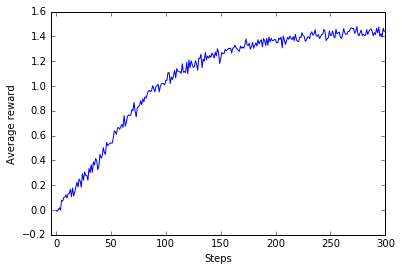

In [30]:
k = 10
numsteps = 300
numtasks = 2000
alpha = 0.1

avgR = np.zeros((numsteps, ))
for task in range(2000):
    bandit_task = gradient_bandit(k,numsteps, alpha)
    avgR += bandit_task['R']
avgR /= numtasks

plt.plot(avgR) ;
plt.ylabel('Average reward') ;
plt.xlabel('Steps') ;
plt.xlim(-5) ;